# Tarea 3: Los K-vecinos 

## Introducción

<img src="vecinos.png" width="400">

Los $K$-vecinos es un método clásico y muy sencillo para hacer clasificación de datos, que se basa en predecir la etiqueta de un dato basado en las etiquetas de los datos de entrenamiento que más se le parecen. La siguiente figura describe graficamente los tres pasos del algoritmo

<img src="algoritmo.png" width="600">

En este caso es clave definir una noción de distancia entre los ejemplos y también especificar un valor adecuado para $K$, la cantidad de vecinos que influyen en la predicción.

## Formalismo matemático

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C-1\}$ son sus etiquetas de clase. Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas. El objetivo es clasificar los ejemplos de $T$ en base a las etiquetas de los $K$ ejemplos más cercanos de la base de datos $E$


El algoritmo para clasificar el i-esimo elemento de Z es

**Paso 1** Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando

$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$

que se conoce como [distancia de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance). Para el caso $p=2$ se recupera la clásica distancia euclidiana.

**Paso 2** Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$

**Paso 3** Seleccionamos la clase de $z_i$ según

$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$

donde 

$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$

se conoce como función indicadora. Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado, ya que una menor distancia (mayor cercanía) aumenta el peso del voto

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **23:59 del Martes 20 de Julio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Instrucciones de la actividad

- (1pt) Considere la implementación "ingenua" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de `N=1000` datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- (2pt) Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- (2pt) Usando la nueva versión de `KNN` y el conjunto de `N=1000` datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- (1pt) Evalue su mejor clasificador en el conjunto $T$ y haga un reporte completo de resultados que incluya curvas ROC y las métricas vistas en el curso. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

A continuación se muestra una gráfica con los datos a utilizar en esta tarea

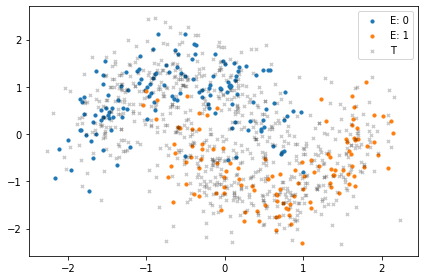

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

In [21]:
%timeit KNN(x,y,z)

1.36 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
#%prun -s cumtime  KNN(x,y,z)

<img src="datos.png">

In [4]:
import line_profiler
%load_ext line_profiler
#%lprun -f KNN KNN(x,y,z)

<img src="datos2.png">

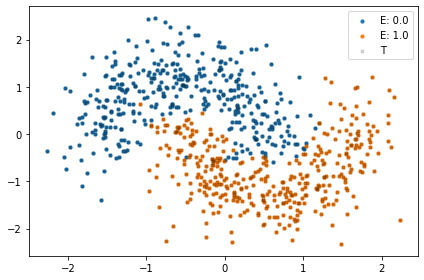

In [5]:
y = KNN(x,y,z)
x = z
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

## Reporte sus resultados y comente sobre los cuellos de botella del algoritmo!!!!

In [6]:
######Prueba -Borrar !!############
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

######################################Borrar igual##############33
X = x
Y = y
Z = z

k=5

p=2.

C = [0,1]

N, D = X.shape
#print(N,D)
M, _ = Z.shape
#print(Z.shape)
#print("M,_ = ",M,_)
#print("################")
dist = np.zeros(shape=(M, N))

for i in range(M):
    for j in range(N):
        dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
        
neighbours = np.argsort(dist, axis=1)[:, :k]
Z_Y = np.zeros(shape=(M, ))
for i in range(M):
    #lista de zeros de largo C ([0,1])
    criterion_c = np.zeros(shape=(len(C),))
    for c in C:
        #arreglo con las pos de sus k vecinos
        #arreglo_pos_vecinos = neighbours[i]

        #arreglo con valores true o false dependiendo de si son 1 o 0 
        #arreglo_true_false_vecinos = (Y[neighbours[i]] == c)

        #dist de los k vecinos si son igual a c=0 o c=1
        #modificar para cython
        #dist_k_vec = dist[i,arreglo_pos_vecinos][arreglo_true_false_vecinos]
        
        for a in range(k):
            criterion_c[c] += (1./dist[i][neighbours[i][a]] if Y[neighbours[i][a]] == c else 0)
        
    if (criterion_c[0]>=criterion_c[1]):
        Z_Y[i] = 0.0
    else:
        Z_Y[i] = 1.0

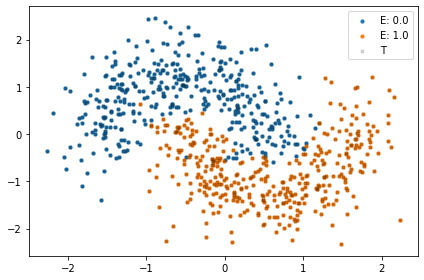

In [7]:
y = Z_Y
x = z
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

In [8]:
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
z, w = T # Use las etiquetas w para evaluar sus resultados finales

In [9]:
%load_ext cython

In [16]:
%%cython
import cython
from libc.stdio cimport printf
import array

cimport numpy as npc
import numpy as np

# Tipo fusionado
ctypedef fused TIPO_t:
    npc.float32_t
    npc.float64_t # double

cdef extern from "math.h":
    npc.float32_t sqrtf(npc.float32_t) #Definición para float32
    npc.float64_t sqrt(npc.float64_t) # Definición para float64
    
def KNN_new(TIPO_t [:, ::1] X, Y, Z, int k, double p):
    
    C = np.unique(Y)
    cdef int N = X.shape[0]
    cdef int D = X.shape[1]
    M, _ = Z.shape
    
    #####################
    dist = np.empty(shape=(M, N), dtype=np.double)
    
    cdef double [:, ::1] dist_c = dist
    cdef double suma = 0.0
    cdef int i,j
    
    for i in range(M):
        for j in range(N):
            for k in range(D):
                suma += (abs(Z[i][k] - X[j][k]))**p
            dist_c[i, j] = suma**(1./p)
            suma = 0.0
    

    neighbours = np.argsort(dist_c, axis=1)[:, :k]
    Z_Y = np.zeros(shape=(M, ))
    for i in range(M):
        #lista de zeros de largo C ([0,1])
        criterion_c = np.zeros(shape=(len(C),))
        for c in C:
            for a in range(k):
                criterion_c[c] += (1./dist[i][neighbours[i][a]] if Y[neighbours[i][a]] == c else 0)
        if (criterion_c[0]>=criterion_c[1]):
            Z_Y[i] = 0.0
        else:
            Z_Y[i] = 1.0
    return Z_Y

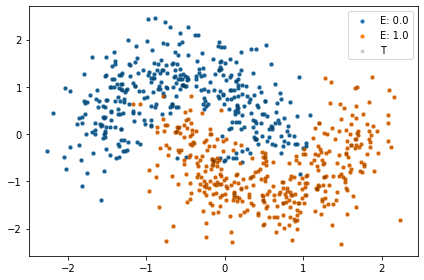

In [17]:
y_new = KNN_new(x,y,z,5,2.)
x_new = z
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
for c in np.unique(y_new):
    mask = y_new == c
    ax.scatter(x_new[mask, 0], x_new[mask, 1], label=f"E: {c}", s=10)
ax.scatter(z[:, 0], z[:, 1], c='k', s=10, marker='x',  alpha=0.2, label='T')
ax.legend();

In [19]:
%timeit -r3 -n1 KNN(x,y,z,5,2) 

1.42 s ± 22.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [20]:
%timeit -r3 -n1 KNN_new(x,y,z,5,2)

168 ms ± 1.07 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
